## Modélisation de la régression logistique

In [145]:
# import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [146]:
# import du dataset
dataset = pd.read_csv('sba_national_clean.csv')

### Constitution du train/test

In [147]:
from sklearn.model_selection import train_test_split

In [148]:
# suppression des variables non-nécessaires pour le modèle
dataset = dataset.drop(['LoanNr_ChkDgt','Name','City','Zip','Bank','ApprovalDate','ApprovalFY','ChgOffDate','DisbursementDate','DisbursementGross','BalanceGross','ChgOffPrinGr','SBA_Appv'],axis=1)

Travailler sur les variables 'NoEmp', 'ApprovalDate', 'ApprovalFY'

In [149]:
dataset.sample(1)

,State,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,crysis_year
406073,KS,OH,42,84,4,2,0,4,0,1,2,1,1,25000.0,no


In [150]:
# Séparation du dataset en dataset d'entrainement et de test
X = dataset.drop("MIS_Status", axis=1)
y = dataset["MIS_Status"]

# test_size de 10% puisque beaucoup de données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Pipeline

In [151]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [152]:
# Identification des variables numériques et catégorielles pour le preproccessing
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [153]:

# Pipeline pour le preproccessing des variables numériques
numerical_pipeline = Pipeline([
    # Imputation des valeurs manquantes
    ('imputer', SimpleImputer(strategy='mean')),
    # Normalisation des données numériques
    ('scaler', StandardScaler())
])

# Pipeline pour le preproccessing des données catégorielles
categorical_pipeline = Pipeline([
    # Imputation des valeurs manquantes
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Encodage des variables catégorielles
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

# Combinaison des deux pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Création de la pipeline finale avec le preproccessing et modèle de régression logistique avec pondération des classes prédites
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

In [154]:
# Entraînement du modèle
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['State', 'BankState', 'crysis_year'], dtype='object'))])),
                ('classifier', LogisticRegression(class_weight='balanced'))])

### Evaluation du modèle de régression logistique

In [155]:
# Prédictions sur le jeu d'entrainement
y_train_pred = pipeline.predict(X_train)

# Prédictions sur le jeu de test
y_test_pred = pipeline.predict(X_test)

In [156]:
# Évaluation avec les métriques recall, precision et f1-score

# avec les données d'entrainement
print("Scores sur les données d'entrainement")
print("Classification Report:\n", classification_report(y_train, y_train_pred))
print()

# avec les données de test
print("Scores sur les données de test")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Scores sur les données d'entrainement
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.82      0.53    126104
           1       0.95      0.73      0.82    591629

    accuracy                           0.74    717733
   macro avg       0.67      0.77      0.68    717733
weighted avg       0.85      0.74      0.77    717733


Scores sur les données de test
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.82      0.53     31454
           1       0.95      0.73      0.82    147980

    accuracy                           0.74    179434
   macro avg       0.67      0.77      0.68    179434
weighted avg       0.85      0.74      0.77    179434



In [157]:
from sklearn.metrics import roc_curve, auc

roc_auc = 0.7730232678861284


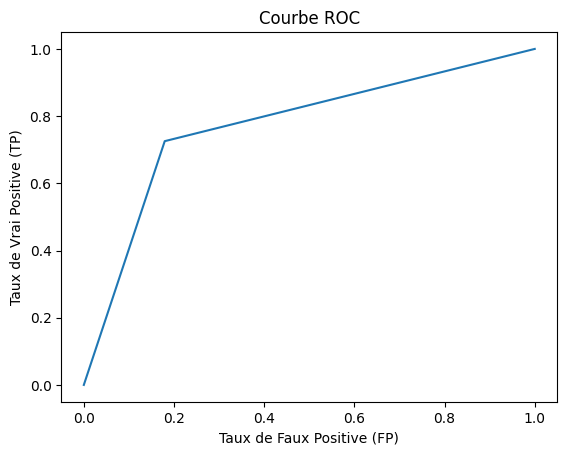

In [158]:
# visualisation de la courbe ROC pour les données de test
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)

print(f"roc_auc = {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("Taux de Faux Positive (FP)")
plt.ylabel("Taux de Vrai Positive (TP)")
plt.title("Courbe ROC")
plt.show()

In [159]:
# Évaluation avec les métriques recall, precision et f1-score
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.82      0.53     31454
           1       0.95      0.73      0.82    147980

    accuracy                           0.74    179434
   macro avg       0.67      0.77      0.68    179434
weighted avg       0.85      0.74      0.77    179434



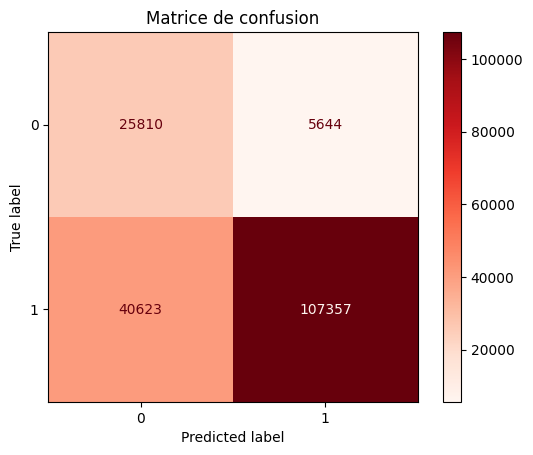

In [160]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Reds")
plt.title('Matrice de confusion')
plt.show()

In [161]:
# score Log-Loss (évaluation de la qualité des probabilités prédites)
from sklearn.metrics import log_loss

print(f'Log-Loss: {log_loss(y_test, y_pred)}')

Log-Loss: 9.293844596644355


## Implémentation du modèle XGBOOST

In [162]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [163]:
# Création de la pipeline finale avec le preproccessing et modèle de boosting
pipeline_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators = 2, max_dept=2, learning_rate=1, objective='binary:logistic'))  # Régression logistique
])

In [164]:
# Entrainement du modèle xgboost avec les données d'entrainement
pipeline_2.fit(X_train, y_train)

c:\Users\nicol\OneDrive\Bureau\simplon\20250203_us_sba\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06a9e5273d3715f33-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "max_dept" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='mos...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_dept=2, max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=2, n_jobs=None,
                               num_parallel_tree=None, ...))])

### Evaluation du modèle xgboost

In [165]:
# Prédictions sur le jeu d'entrainement
y_train_pred2 = pipeline_2.predict(X_train)

# Prédictions sur le jeu de test
y_test_pred2 = pipeline_2.predict(X_test)

In [166]:
# Évaluation avec les métriques recall, precision et f1-score

# avec les données d'entrainement
print("Scores sur les données d'entrainement")
print("Classification Report:\n", classification_report(y_train, y_train_pred2))
print()

# avec les données de test
print("Scores sur les données de test")
print("Classification Report:\n", classification_report(y_test, y_test_pred2))

Scores sur les données d'entrainement
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.77    126104
           1       0.94      0.97      0.96    591629

    accuracy                           0.92    717733
   macro avg       0.89      0.84      0.86    717733
weighted avg       0.92      0.92      0.92    717733


Scores sur les données de test
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.77     31454
           1       0.94      0.97      0.96    147980

    accuracy                           0.92    179434
   macro avg       0.89      0.84      0.86    179434
weighted avg       0.92      0.92      0.92    179434



roc_auc = 0.8366093355979384


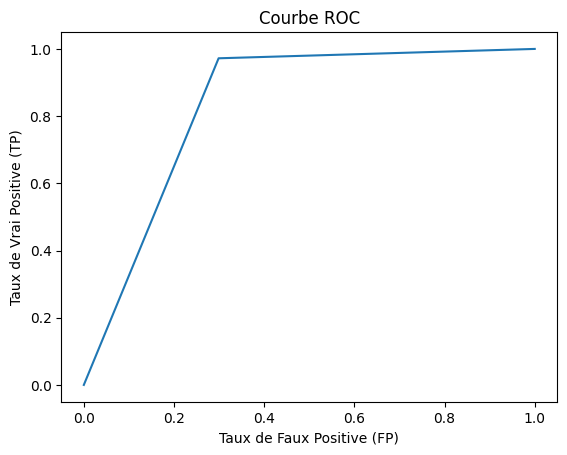

In [167]:
fpr, tpr, _ = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr,tpr)

print(f"roc_auc = {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("Taux de Faux Positive (FP)")
plt.ylabel("Taux de Vrai Positive (TP)")
plt.title("Courbe ROC")
plt.show()

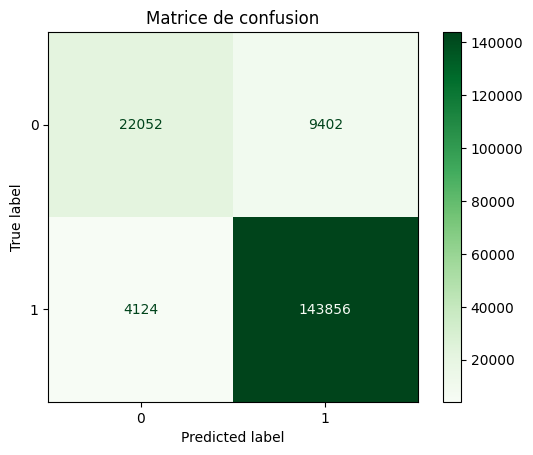

In [168]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens")
plt.title('Matrice de confusion')
plt.show()